<a href="https://colab.research.google.com/github/ChinmayNakwa/Image_Segmentation/blob/main/Drywall_Join_Detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 65.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="zrTfNs2Xx5ATQrPmKETi")
project = rf.workspace("chinmay-k5q2n").project("drywall-join-detect-jxjdl")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Drywall-Join-Detect-1 in coco:: 100%|██████████| 2670/2670 [00:00<00:00, 4675.16it/s]


In [ ]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 41.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.3
    Uninstalling transformers-4.57.3:
      Successfully uninstalled transformers-4.57.3


In [ ]:
!pip install timm

In [ ]:
import transformers
print(f"Transformers version: {transformers.__version__}")

from transformers import AutoProcessor, CLIPSegForImageSegmentation
print("Success! Model loaded.")

import torch
import numpy as np
import random
import os
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import json


Transformers version: 4.57.6
Success! Model loaded.


### Convert COCO polygon annotations into pixel-wise binary masks
Each mask corresponds to one input image

In [ ]:
def create_masks_from_coco(dataset_root_path):
    dataset_path = Path(dataset_root_path)
    subsets = ['train', 'valid', 'test']

    for subset in subsets:
        json_file = dataset_path / subset / "_annotations.coco.json"
        if not json_file.exists():
            continue

        print(f"Processing {subset} set...")
        with open(json_file, 'r') as f:
            coco = json.load(f)

        mask_dir = dataset_path / subset / "masks"
        mask_dir.mkdir(exist_ok=True)

        img_map = {img['id']: img for img in coco['images']}

        # Group annotations by image_id
        img_annotations = {}
        for ann in coco['annotations']:
            img_annotations.setdefault(ann['image_id'], []).append(ann)

        for img_id, img_info in tqdm(img_map.items()):
            file_name = img_info['file_name']
            W, H = img_info['width'], img_info['height']

            mask = Image.new('L', (W, H), 0)
            draw = ImageDraw.Draw(mask)

            if img_id in img_annotations:
                for ann in img_annotations[img_id]:
                    if 'segmentation' in ann and ann['segmentation']:
                        for seg in ann['segmentation']:
                            poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                            draw.polygon(poly, fill=255)
                    else:
                        x, y, w_box, h_box = ann['bbox']
                        draw.rectangle([x, y, x + w_box, y + h_box], fill=255)

            base_name = Path(file_name).stem
            mask.save(mask_dir / f"{base_name}.png")

    print("✅ All masks generated with Polygons (where available)")

In [ ]:
create_masks_from_coco("Drywall-Join-Detect-1")

Processing train set...


100%|██████████| 2460/2460 [00:03<00:00, 722.68it/s]


Processing valid set...


100%|██████████| 101/101 [00:00<00:00, 866.68it/s]


Processing test set...


100%|██████████| 101/101 [00:00<00:00, 855.86it/s]

✅ All masks generated with Polygons (where available)


In [ ]:
dataset_folder_name = '/content/Drywall-Join-Detect-1'

### Visualize Image and Generated Mask

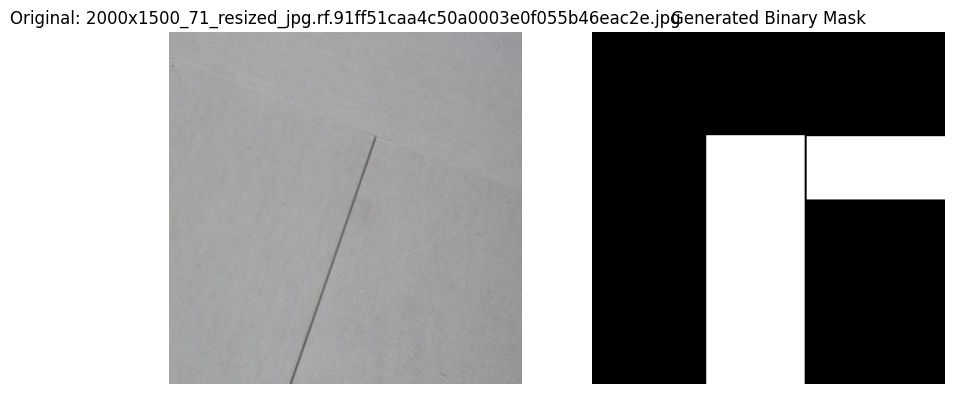

In [ ]:
import matplotlib.pyplot as plt
import random

def show_random_sample(dataset_root_path, subset='train'):
    path = Path(dataset_root_path) / subset
    image_files = list(path.glob("*.jpg")) + list(path.glob("*.jpeg"))

    if not image_files:
        print("No images found.")
        return

    img_path = random.choice(image_files)
    base_name = img_path.stem
    mask_path = path / "masks" / f"{base_name}.png"

    if not mask_path.exists():
        print(f"Mask not found for {img_path.name}")
        return

    img = Image.open(img_path)
    mask = Image.open(mask_path)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[0].set_title(f"Original: {img_path.name}")
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Generated Binary Mask")
    ax[1].axis('off')
    plt.show()

show_random_sample(dataset_folder_name)

### Visualize an image with its segmentation mask overlay

In [ ]:
def show_overlay(dataset_root_path, subset='train', alpha=0.5):
    path = Path(dataset_root_path) / subset
    image_files = list(path.glob("*.jpg")) + list(path.glob("*.jpeg"))

    img_path = random.choice(image_files)
    base_name = img_path.stem
    mask_path = path / "masks" / f"{base_name}.png"

    img = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.imshow(mask, cmap="Reds", alpha=alpha)
    plt.title("Mask Overlay")
    plt.axis("off")
    plt.show()


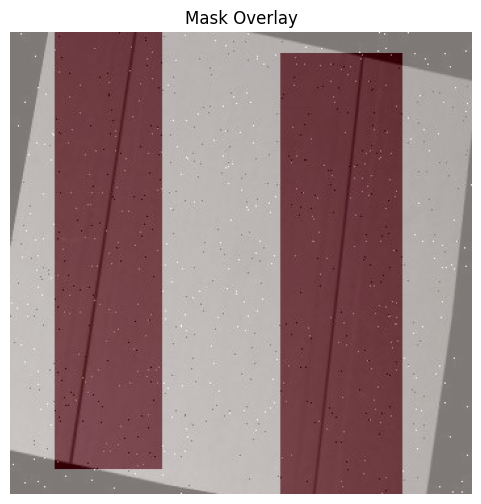

In [ ]:
show_overlay(dataset_folder_name)

### Select GPU (CUDA) if available, otherwise fall back to CPU

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


Using device: cuda


### Custom PyTorch Dataset for text-guided image segmentation
 Each sample consists of:
   - an image
   - a text prompt describing the task
   - a binary segmentation mask (ground truth)


In [ ]:
class TextSegDataset(Dataset):
    def __init__(self, dataset_path, split, prompt, processor):
        self.root = Path(dataset_path) / split
        self.images = sorted(
            list(self.root.glob("*.jpg")) +
            list(self.root.glob("*.jpeg"))
        )
        self.prompt = prompt
        self.processor = processor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")

        base = img_path.stem
        mask_path = self.root / "masks" / f"{base}.png"

        if mask_path.exists():
            mask = Image.open(mask_path).convert("L")
        else:
            mask = Image.new("L", image.size, 0)

        if isinstance(self.prompt, list):
            prompt = random.choice(self.prompt)
        else:
            prompt = self.prompt


        inputs = self.processor(
            text=prompt,
            images=image,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # mask = mask.resize((352, 352), Image.NEAREST)
        mask = np.array(mask) / 255.0
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return {
            "pixel_values": inputs.pixel_values.squeeze(0),
            "input_ids": inputs.input_ids.squeeze(0),
            "attention_mask": inputs.attention_mask.squeeze(0),
            "labels": mask
        }


### Training Pipeline Overview

1. **Model Setup**
   - Load a pretrained CLIPSeg model for text-guided image segmentation
   - Move the model to the selected computation device (CPU/GPU)

2. **Partial Fine-Tuning Strategy**
   - Freeze most CLIP layers to preserve pretrained representations
   - Unfreeze the last vision encoder layers for task-specific learning
   - Train the segmentation decoder for drywall joint detection

3. **Dataset & Prompt Design**
   - Prepare custom datasets for training and validation
   - Use multiple text prompts during training to improve robustness
   - Use a fixed evaluation prompt for consistent validation

4. **Optimization & Training**
   - Optimize the model using a combined Dice + Binary Cross-Entropy loss
   - Apply different learning rates for decoder and encoder layers
   - Use a Cosine Annealing Learning Rate Scheduler for stable convergence

5. **Evaluation & Metrics**
   - Evaluate segmentation performance using Dice score
   - Measure region overlap using mean Intersection over Union (mIoU)
   - Track training loss, validation metrics, and learning rate across epochs


In [ ]:
MODEL_ID = "CIDAS/clipseg-rd64-refined"

processor = AutoProcessor.from_pretrained(MODEL_ID)
model = CLIPSegForImageSegmentation.from_pretrained(MODEL_ID)
model.to(device)

for param in model.clip.parameters():
    param.requires_grad = False

for param in model.clip.vision_model.encoder.layers[-2:].parameters():
  param.requires_grad = True


print("✅ Model loaded and CLIP frozen")


✅ Model loaded and CLIP frozen


In [ ]:
DATASET_DIR = "Drywall-Join-Detect-1"
TRAIN_PROMPTS = [
    "segment drywall joint tape",
    "segment white drywall mud seams",
    "segment the taped joints",
    "drywall finishing tape",
]

EVAL_PROMPT = "segment taping area"


train_ds = TextSegDataset(DATASET_DIR, "train", TRAIN_PROMPTS, processor)
val_ds   = TextSegDataset(DATASET_DIR, "valid", EVAL_PROMPT, processor)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)

print(f"Train samples: {len(train_ds)}")
print(f"Val samples:   {len(val_ds)}")


Train samples: 2460
Val samples:   101


In [ ]:
class DiceBCELoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Flatten
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Dice Calculation
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        # BCE Calculation
        bce = torch.nn.functional.binary_cross_entropy(inputs, targets, reduction='mean')

        return dice_loss + bce

criterion = DiceBCELoss()

In [ ]:
pos_weight = torch.tensor([3.0]).to(device)

optimizer = AdamW([
    {'params': model.decoder.parameters(), 'lr': 5e-5},
    {'params': model.clip.vision_model.encoder.layers[-2:].parameters(), 'lr': 2e-6}
])

EPOCHS = 15

scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

history = {
    'train_loss': [],
    'val_dice': [],
    'val_miou': [],
    'learning_rate': []
}

def dice_score(pred, gt):
    """
    Compute Dice score for binary segmentation
    pred, gt: tensors of shape [B, 1, H, W] or [B, H, W]
    """
    pred = (pred > 0.5).float()
    gt = (gt > 0.5).float()

    # Flatten spatial dimensions but keep batch separate
    pred = pred.view(pred.size(0), -1)
    gt = gt.view(gt.size(0), -1)

    intersection = (pred * gt).sum(dim=1)
    dice = (2 * intersection) / (pred.sum(dim=1) + gt.sum(dim=1) + 1e-6)

    return dice.mean()

def iou_score(pred, gt):
    """
    Compute IoU score for binary segmentation
    """
    pred = (pred > 0.5).float()
    gt = (gt > 0.5).float()

    pred = pred.view(pred.size(0), -1)
    gt = gt.view(gt.size(0), -1)

    intersection = (pred * gt).sum(dim=1)
    union = (pred + gt).clamp(0, 1).sum(dim=1)
    iou = intersection / (union + 1e-6)

    return iou.mean()

def miou_score(pred, gt):
    """
    Compute mean IoU across both classes (foreground and background)
    """
    pred = (pred > 0.5).float()
    gt = (gt > 0.5).float()

    pred = pred.view(pred.size(0), -1)
    gt = gt.view(gt.size(0), -1)

    # Foreground IoU
    intersection_fg = (pred * gt).sum(dim=1)
    union_fg = (pred + gt).clamp(0, 1).sum(dim=1)
    iou_fg = intersection_fg / (union_fg + 1e-6)

    # Background IoU
    pred_bg = 1 - pred
    gt_bg = 1 - gt
    intersection_bg = (pred_bg * gt_bg).sum(dim=1)
    union_bg = (pred_bg + gt_bg).clamp(0, 1).sum(dim=1)
    iou_bg = intersection_bg / (union_bg + 1e-6)

    # Mean of both classes
    miou = (iou_fg + iou_bg) / 2

    return miou.mean()


In [ ]:
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        outputs = model(
            pixel_values=batch["pixel_values"].to(device),
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device)
        )

        preds = outputs.logits.unsqueeze(1)
        loss = criterion(preds, batch["labels"].to(device))

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    dices, ious = [], []

    with torch.no_grad():
        for batch in val_loader:
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device)
            )

            preds = torch.sigmoid(outputs.logits).unsqueeze(1)
            gt = batch["labels"].to(device)

            dice = dice_score(preds, gt)
            miou = miou_score(preds, gt)

            dices.append(dice.item())
            ious.append(miou.item())

    # Store metrics
    avg_loss = train_loss / len(train_loader)
    avg_dice = np.mean(dices)
    avg_miou = np.mean(ious)
    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(avg_loss)
    history['val_dice'].append(avg_dice)
    history['val_miou'].append(avg_miou)
    history['learning_rate'].append(current_lr)

    # Step the scheduler
    scheduler.step()

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Loss: {avg_loss:.4f} | "
        f"Dice: {avg_dice:.4f} | "
        f"mIoU: {avg_miou:.4f} | "
        f"LR: {current_lr:.2e}"
    )

Epoch 1/15 | Loss: 1.1109 | Dice: 0.4113 | mIoU: 0.4865 | LR: 5.00e-05
Epoch 2/15 | Loss: 0.8510 | Dice: 0.5162 | mIoU: 0.5846 | LR: 4.95e-05
Epoch 3/15 | Loss: 0.7453 | Dice: 0.5383 | mIoU: 0.5916 | LR: 4.79e-05
Epoch 4/15 | Loss: 0.6965 | Dice: 0.5633 | mIoU: 0.6113 | LR: 4.53e-05
Epoch 5/15 | Loss: 0.6642 | Dice: 0.5848 | mIoU: 0.6301 | LR: 4.19e-05
Epoch 6/15 | Loss: 0.6436 | Dice: 0.5874 | mIoU: 0.6298 | LR: 3.78e-05
Epoch 7/15 | Loss: 0.6259 | Dice: 0.5901 | mIoU: 0.6292 | LR: 3.31e-05
Epoch 8/15 | Loss: 0.6127 | Dice: 0.5988 | mIoU: 0.6375 | LR: 2.81e-05
Epoch 9/15 | Loss: 0.5996 | Dice: 0.5738 | mIoU: 0.6051 | LR: 2.29e-05
Epoch 10/15 | Loss: 0.5939 | Dice: 0.5820 | mIoU: 0.6149 | LR: 1.79e-05
Epoch 11/15 | Loss: 0.5848 | Dice: 0.5693 | mIoU: 0.5993 | LR: 1.33e-05
Epoch 12/15 | Loss: 0.5821 | Dice: 0.5878 | mIoU: 0.6204 | LR: 9.11e-06
Epoch 13/15 | Loss: 0.5772 | Dice: 0.5836 | mIoU: 0.6158 | LR: 5.68e-06
Epoch 14/15 | Loss: 0.5762 | Dice: 0.5771 | mIoU: 0.6080 | LR: 3.12e-06
E

### Plotting Metrics

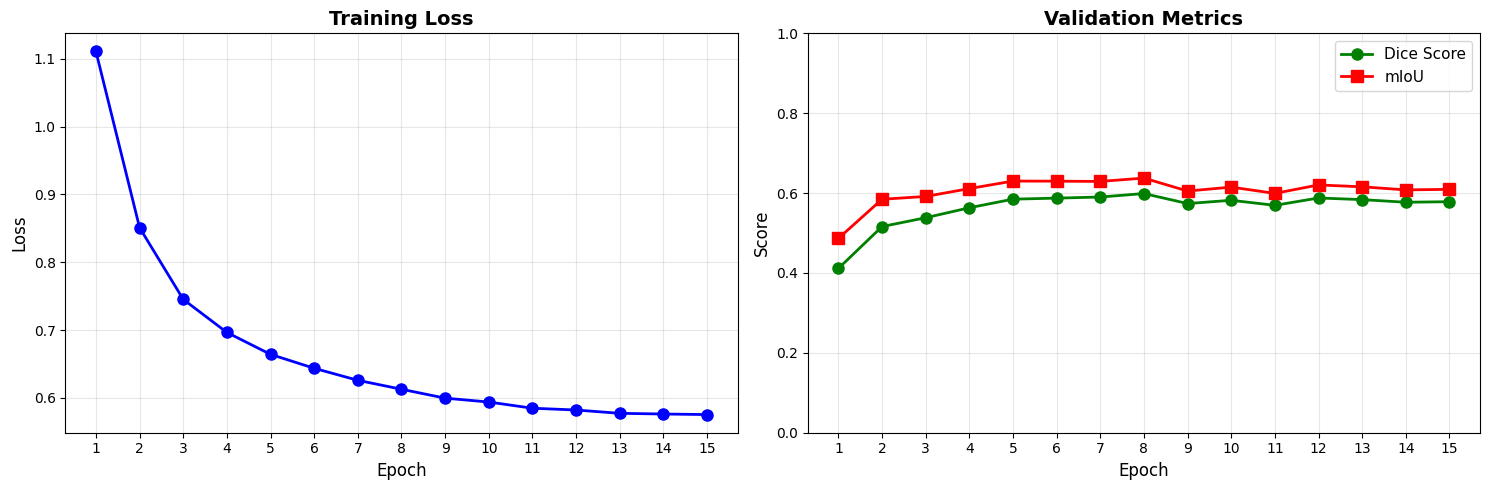


📊 Final Results:
Best Dice Score: 0.5988 at epoch 8
Best mIoU: 0.6375 at epoch 8
Final Loss: 0.5754


In [ ]:

# Plot metrics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training Loss
axes[0].plot(range(1, EPOCHS+1), history['train_loss'], 'b-o', linewidth=2, markersize=8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, EPOCHS+1))

# Plot 2: Validation Metrics
axes[1].plot(range(1, EPOCHS+1), history['val_dice'], 'g-o', linewidth=2, markersize=8, label='Dice Score')
axes[1].plot(range(1, EPOCHS+1), history['val_miou'], 'r-s', linewidth=2, markersize=8, label='mIoU')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Validation Metrics', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(1, EPOCHS+1))
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Final Results:")
print(f"Best Dice Score: {max(history['val_dice']):.4f} at epoch {history['val_dice'].index(max(history['val_dice']))+1}")
print(f"Best mIoU: {max(history['val_miou']):.4f} at epoch {history['val_miou'].index(max(history['val_miou']))+1}")
print(f"Final Loss: {history['train_loss'][-1]:.4f}")

### Visualize 10 random samples from validation set

In [ ]:
def denormalize_clip(img):
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
    std  = torch.tensor([0.26862954, 0.26130258, 0.27577711])
    img = img * std[:, None, None] + mean[:, None, None]
    return img.clamp(0, 1)


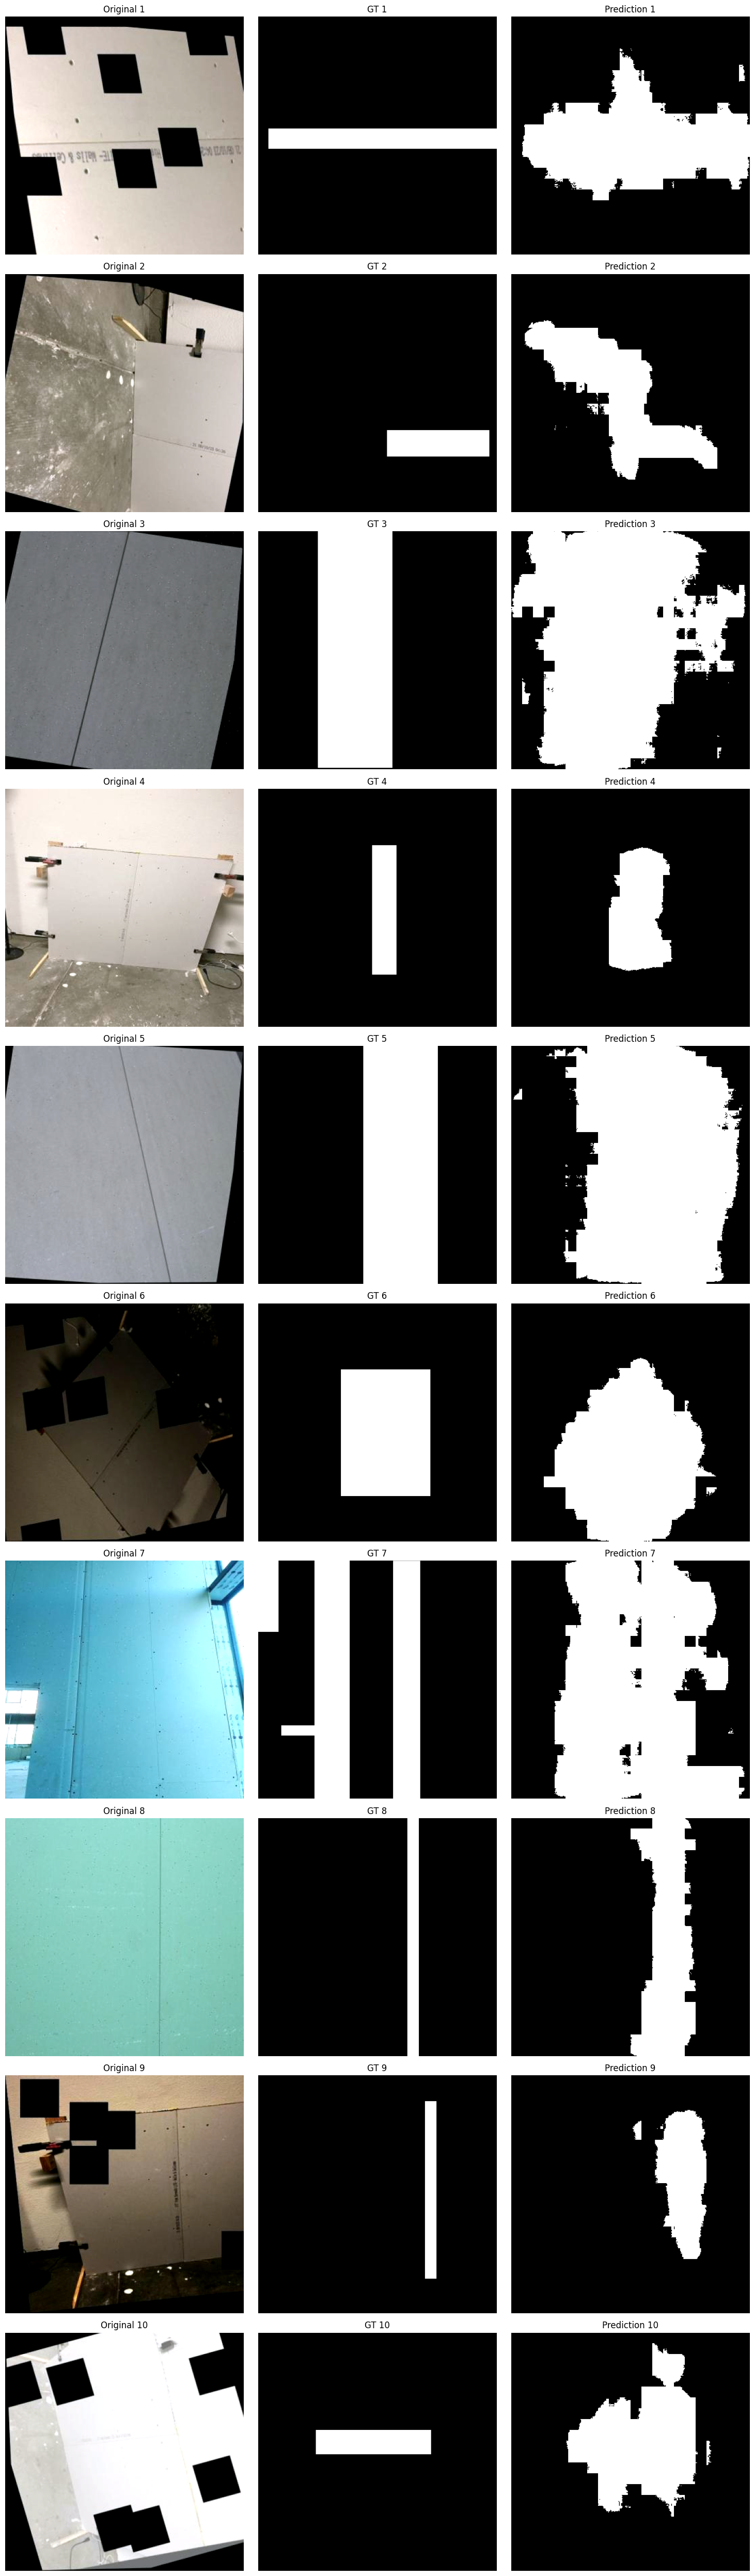

In [ ]:
num_samples = 10
indices = random.sample(range(len(val_ds)), num_samples)

model.eval()

fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

with torch.no_grad():
    for i, idx in enumerate(indices):
        item = val_ds[idx]

        # Get prediction
        outputs = model(
            pixel_values=item["pixel_values"].unsqueeze(0).to(device),
            input_ids=item["input_ids"].unsqueeze(0).to(device),
            attention_mask=item["attention_mask"].unsqueeze(0).to(device)
        )

        # Process prediction
        pred = torch.sigmoid(outputs.logits)
        if pred.ndim == 4:
            pred = pred[0, 0]
        else:
            pred = pred[0]
        pred = pred.cpu().numpy()

        # Ground truth
        gt = item["labels"][0].cpu().numpy()

        # De-normalize image
        img = denormalize_clip(item["pixel_values"]).permute(1, 2, 0)

        # Plot row
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original {i+1}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(gt, cmap="gray")
        axes[i, 1].set_title(f"GT {i+1}")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred > 0.5, cmap="gray")
        axes[i, 2].set_title(f"Prediction {i+1}")
        axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
print("Pred shape:", pred.shape)
print("GT shape:", gt.shape)


Pred shape: (352, 352)
GT shape: (352, 352)


In [ ]:
def show_overlay_prediction(dataset_root_path, model, processor, prompt,
                            subset="valid", alpha=0.5):
    model.eval()
    path = Path(dataset_root_path) / subset
    image_files = list(path.glob("*.jpg")) + list(path.glob("*.jpeg"))

    img_path = random.choice(image_files)
    img = Image.open(img_path).convert("RGB")

    # Prepare input
    inputs = processor(
        text=prompt,
        images=img,
        return_tensors="pt"
    )

    inputs = {k: v.to(next(model.parameters()).device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    # Get prediction mask
    pred = torch.sigmoid(outputs.logits)
    if pred.ndim == 4:
        pred = pred[0, 0]
    else:
        pred = pred[0]

    pred = (pred.cpu().numpy() > 0.5).astype("uint8") * 255

    # Plot overlay
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.imshow(pred, cmap="Reds", alpha=alpha)
    plt.title(f"Prediction Overlay\nPrompt: {prompt}")
    plt.axis("off")
    plt.show()


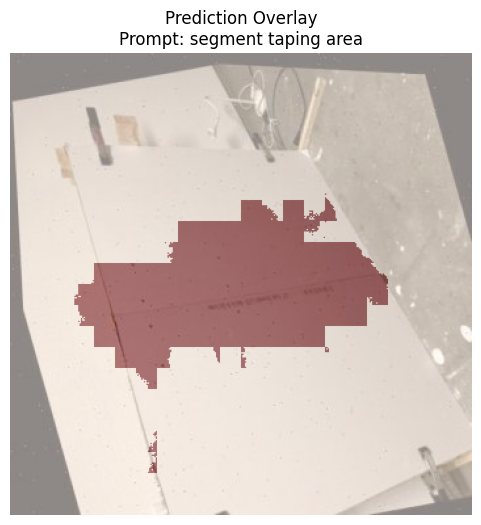

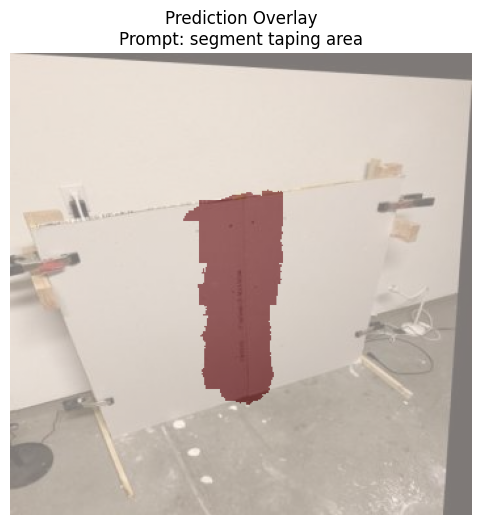

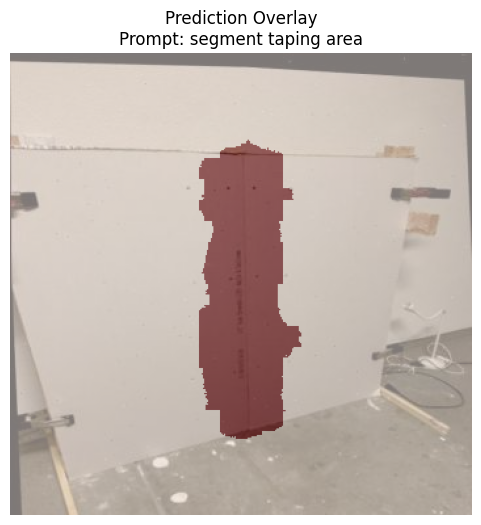

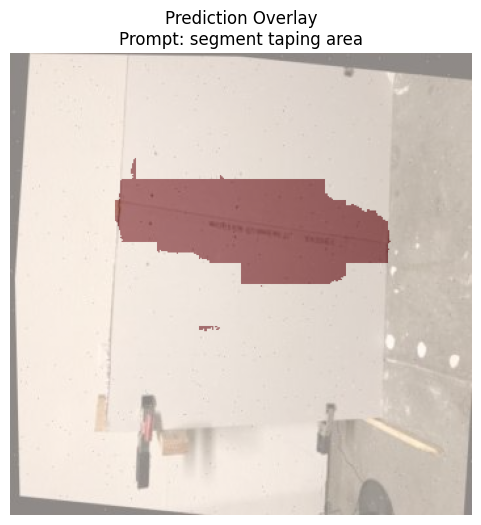

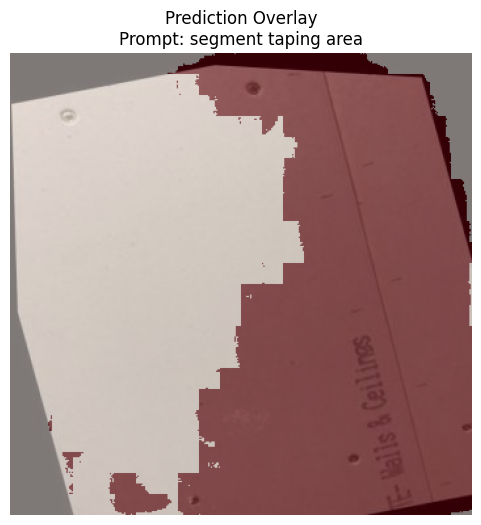

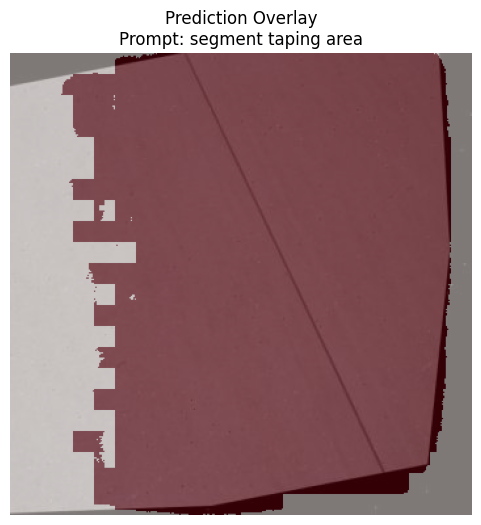

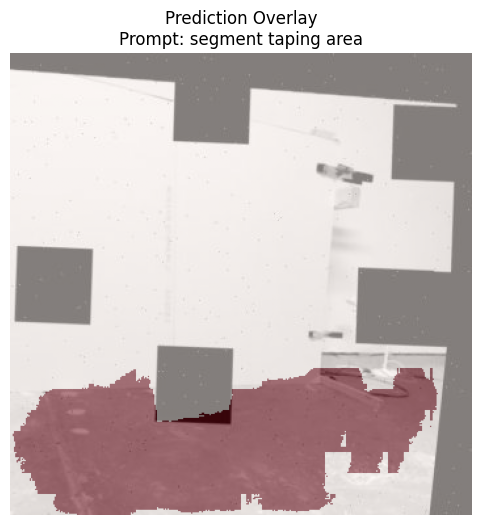

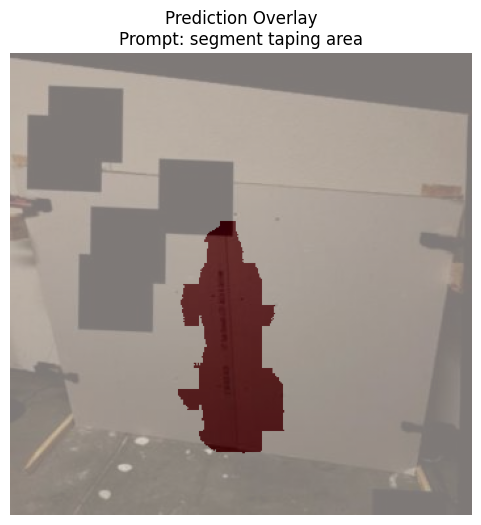

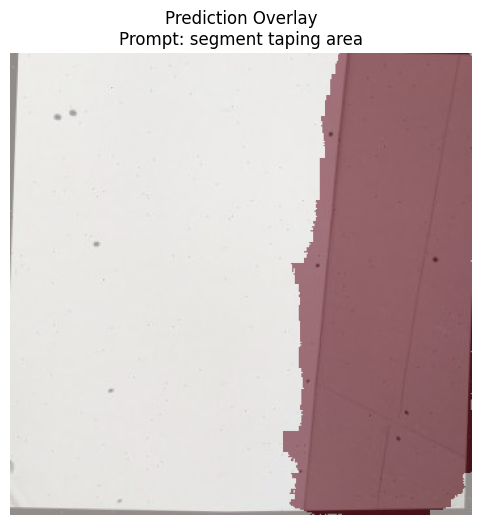

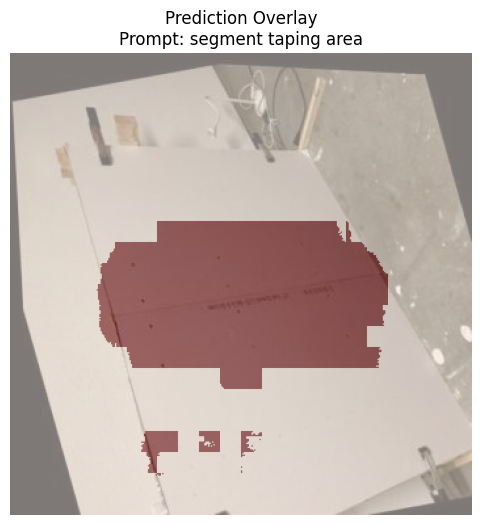

In [ ]:
for i in range(10):
  show_overlay_prediction(
      dataset_root_path=DATASET_DIR,
      model=model,
      processor=processor,
      prompt="segment taping area",
      subset="valid"
  )
